<a href="https://colab.research.google.com/github/AugustinCablant/Viager/blob/main/Estimation_fonction_survie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimation de la fonction de survie

## Importations

In [28]:
!pip install lifelines
!pip install scikit-survival
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Stage')
from tqdm import tqdm
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import random
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import survival_events
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ImportError: ignored

## Charger et mettre en place les données

In [36]:
# Download Data

#df = pd.read_stata('data_tetes_back_match.dta')

#df.head()

#df.to_csv('data_tetes_back_match.csv')

df = pd.read_csv('data_tetes_back_match.csv')

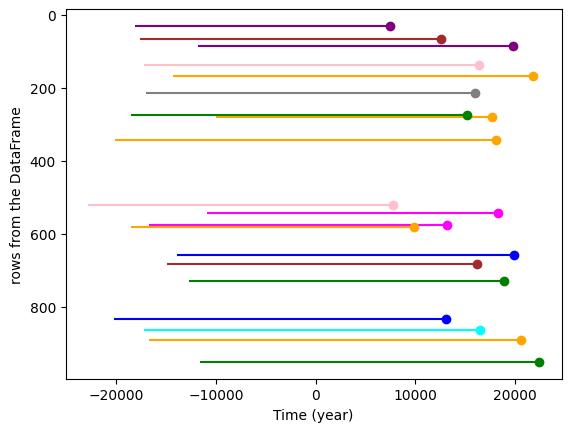

In [ ]:
# Get a randomized sample
samp = df.sample(n=20, random_state=42)

# Colors in matplotlib.pyplot
avaidable_colors = ['blue', 'red', 'green', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan', 'magenta']
avaidable_colors

def plot_lifelines(obs):
    """Plot a line for each observation.

    obs: DataFrame
    """
    for y, row in obs.iterrows():
        start = row['dateN']
        end = row['dateD']

        color = random.choice(avaidable_colors)
        plt.hlines(y, start, end, color=color)
        plt.plot(end, y, marker='o', color=color)

    plt.xlabel('Time (year)')
    plt.ylabel('rows from the DataFrame')
    plt.gca().invert_yaxis()

plot_lifelines(samp)

In [ ]:
# Create Td and Ts (lifetime in days)
df['Td'] = df['dateD'] - df['dateN']
df['Ts'] = df['dateD'] - df['dateA']
#df.to_csv('data_tetes_back_match.csv')

In [ ]:
# Variable Td
print("Descriptive statistics on variable Td : \n", df['Td'].describe())
print("\n")

# Make it easier to read

df['Td_age'] = df['Td']/365

print("Descriptive statistics on variable Td_age : \n", df['Td_age'].describe())
print("\n")

# Variable Ts
print("Descriptive statistics on variable Ts : \n", df['Ts'].describe())
print("\n")

# Make it easier to read

df['Ts_age'] = df['Ts']/365

print("Descriptive statistics on variable Td_age : \n", df['Ts_age'].describe())
print("\n")

Descriptive statistics on variable Td : 
 count      956.000000
mean     32298.490234
std       2675.034668
min      23431.000000
25%      30588.000000
50%      32585.000000
75%      34145.750000
max      38706.000000
Name: Td, dtype: float64


Descriptive statistics on variable Td_age : 
 count    956.000000
mean      88.489006
std        7.328862
min       64.194519
25%       83.802738
50%       89.273975
75%       93.549999
max      106.043839
Name: Td_age, dtype: float64


Descriptive statistics on variable Ts : 
 count      956.000000
mean      4854.049316
std       2975.211914
min        -55.000000
25%       2553.000000
50%       4555.500000
75%       6893.000000
max      14448.000000
Name: Ts, dtype: float64


Descriptive statistics on variable Td_age : 
 count    956.000000
mean      13.298765
std        8.151265
min       -0.150685
25%        6.994521
50%       12.480822
75%       18.884932
max       39.583561
Name: Ts_age, dtype: float64




**What is the Kaplan-Meier estimator?** <br>
<br>
The Kaplan-Meier (KM) estimator is a non-parametric statistic that estimates the survival function of time-to-event data. <br>
<br>
We note : <br>
- $t_i \space \text{a duration time} $
- $ d_i \space \text{number of events that happened at time} \space t_i$
- $n_i \space \text{number of individuals known to have survived up to time}$ <br>
Then, the survival function $S(t)$ is estimated with: $\displaystyle \prod_{i:t_i \le t} (1 - \frac{d_i}{n_i})$.

Here, our variables are doubly truncated. On the one hand, we can carry out the observation if and only if the individual died before June 2023. Secondly, we consider the survival period from the date on which the life annuity contract was signed.  <br>Let's give a few notations :
<br> <br>
$T_i$ is the lifetime of the seller, $T_{i,birth}$ the date of birth of seller $i$, $T_c$ the date of the contract signature and $T_{end}$ 1 June 2023. <br>
People $i$ is included in the sample if and only if: <br> $$ T_{i,birth} + T_i \le T_{end} \space \space \text{and} \space \space T_{i,birth} + T_i \ge T_c$$.

## Get some training with data_back_match dataset (does not include clones)

In [ ]:
# Kaplan-Meier estimation

kmf = KaplanMeierFitter()
Ts = df.sort_values(by = 'Ts',ascending=True)
n = Ts.shape[0]
E = [1]*n
kmf.fit(Ts['Ts'], E)
kmf.survival_function_

,KM_estimate
timeline,
-55.0,0.998954
-1.0,0.997908
15.0,0.996862
22.0,0.995816
69.0,0.994770
...,...
13191.0,0.004184
13295.0,0.003138
13592.0,0.002092


In [ ]:
# Confidence interval
ci = kmf.confidence_interval_survival_function_
ci

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
-55.0,0.992598,0.999853
-1.0,0.991661,0.999476
15.0,0.990302,0.998987
22.0,0.988891,0.998428
69.0,0.987481,0.997820
...,...,...
13191.0,0.001434,0.010246
13295.0,0.000901,0.008755
13592.0,0.000443,0.007230
13607.0,0.000108,0.005750


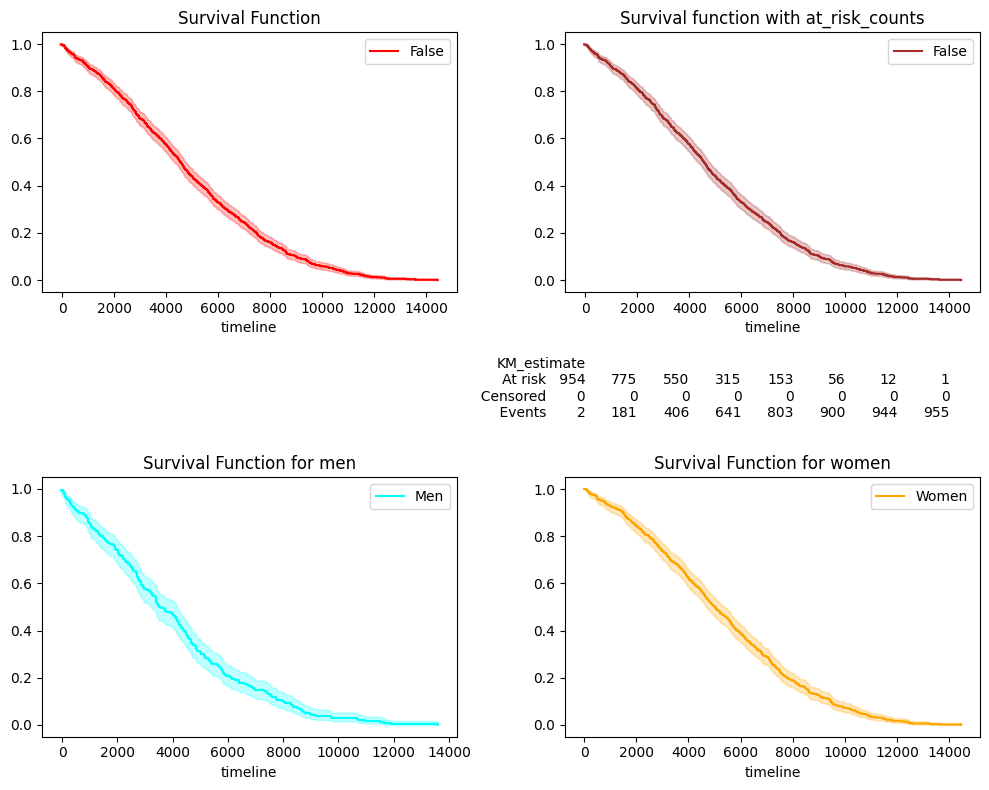

In [ ]:
# Representing our survival curves
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

kmf = KaplanMeierFitter()
kmf.fit(Ts['Ts'], event_observed=E)
kmf.plot_survival_function(ax=axes[0, 0], color = 'red', label = False)
axes[0, 0].set_title('Survival Function')

# Tracer la courbe de survie avec le critère 'at_risk_counts'
kmf.plot_survival_function(ax=axes[0, 1], at_risk_counts=True, color = 'brown', label = False)
axes[0, 1].set_title('Survival function with at_risk_counts')

# Men
sex = Ts['b_sexe'] == 1
kmf.fit(Ts[sex]['Ts'], event_observed= [1]*int(Ts[sex].shape[0]), label="Men")
kmf.plot_survival_function(ax=axes[1, 0], color = 'cyan')
axes[1, 0].set_title('Survival Function for men')

# Women
kmf.fit(Ts[~sex]['Ts'], event_observed= [1]*int(Ts[~sex].shape[0]), label="Women")
kmf.plot_survival_function(ax=axes[1, 1], color = 'orange')
axes[1, 1].set_title('Survival Function for women')

plt.tight_layout()
plt.show()

## With our main data set :

In [ ]:
# Download Data

#df = pd.read_stata('Newclones_HF.dta')

#df.to_csv('Newclones_HF.csv')

<ipython-input-76-5035dc3cac0a>:3: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df = pd.read_stata('Newclones_HF.dta')


In [2]:
# Download Data
df = pd.read_csv('Newclones_HF.csv')

# Keeping the "valid clones"
df = df[df['b_dateD'] >= df['dateA']]

# Create Td and Ts (lifetime in days)
df['Td'] = df['b_dateD'] - df['b_dateN']
df['Ts'] = df['b_dateD'] - df['dateA']

# Create the clone variable which is 1 if the individual is a clone
# and 0 otherwise (individual from the agency dataset)

agency = pd.read_csv('data_tetes_back_match.csv')
df['clone'] = 1

for i in tqdm(agency.index.to_list()):
  id = agency['id'][i]
  prenoms = agency['b_prenoms'][i]
  nom = agency['b_nom'][i]
  sex = agency['b_sexe'][i]

  sub_df = df[df['id']==id]

  for k in sub_df.index.to_list():
    compteur = 0
    if sub_df['b_nom'][k]==nom and sub_df['b_prenoms'][k]==prenoms and sub_df['b_sexe'][k]==sex:
      compteur += 1
      df['clone'][k] = 0

    if compteur > 1:
      print(nom,prenoms)

<ipython-input-2-77e346bb5a92>:2: DtypeWarning: Columns (14,26,41,45,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Newclones_HF.csv')
  0%|          | 0/956 [00:00<?, ?it/s]<ipython-input-2-77e346bb5a92>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clone'][k] = 0
100%|██████████| 956/956 [00:04<00:00, 200.91it/s]


In [45]:
# Kaplan-Meier estimation

kmf = KaplanMeierFitter()
Ts = df.sort_values(by = 'Ts',ascending=True)
n = Ts.shape[0]
E = [1]*n
kmf.fit(Ts['Ts'], E)
kmf.survival_function_

,KM_estimate
timeline,
0.0,0.999918
1.0,0.999825
2.0,0.999748
3.0,0.999648
4.0,0.999573
...,...
15331.0,0.000010
15353.0,0.000007
15384.0,0.000005


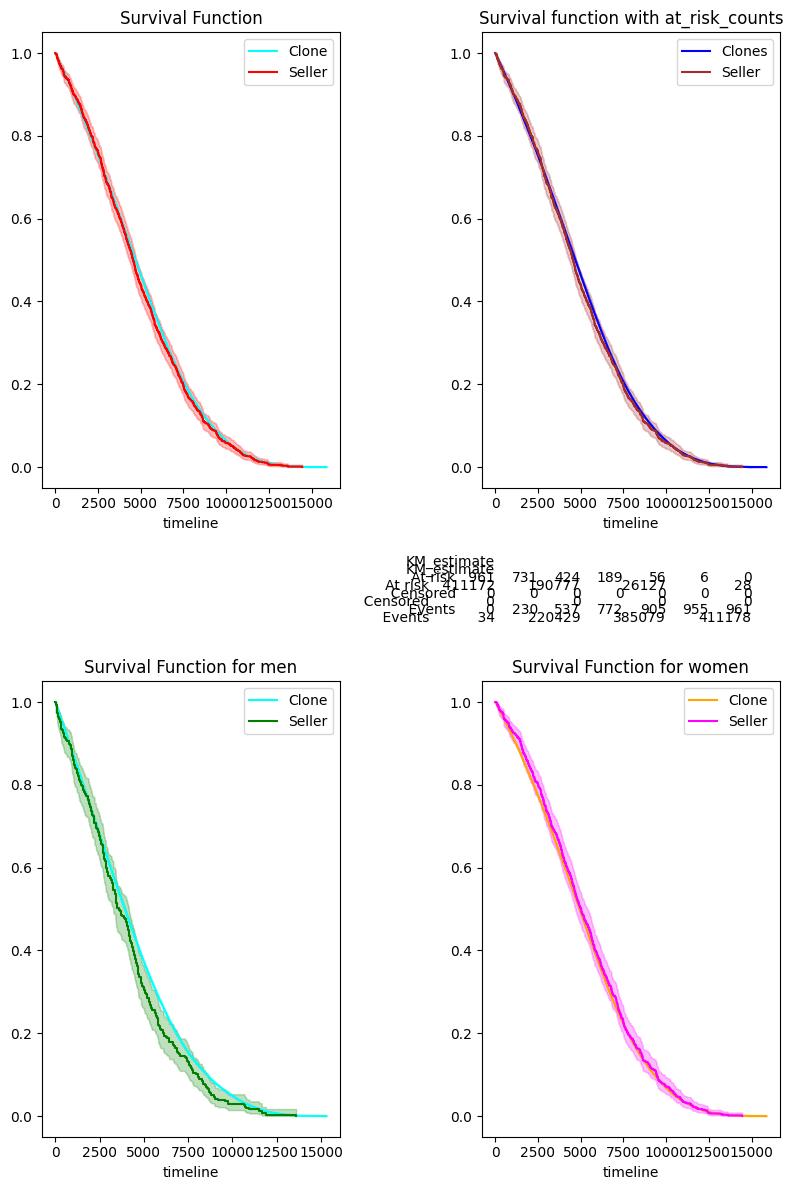

In [52]:
# Representing our survival curves
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 12))

# Divide clones
Clone = Ts[Ts['clone'] == 1]
People = Ts[Ts['clone'] == 0]

km1 = KaplanMeierFitter()
km2 = KaplanMeierFitter()

km1.fit(Clone['Ts'], event_observed= [1]*Clone.shape[0])
km1.plot_survival_function(ax=axes[0, 0], label= 'Clone', color = 'cyan')

km2.fit(People['Ts'], event_observed= [1]*People.shape[0])
km2.plot_survival_function(ax=axes[0, 0], label="Seller", color = 'red')

axes[0, 0].set_title('Survival Function')

# Survival function 'at_risk_counts'
km1.plot_survival_function(ax=axes[0, 1], at_risk_counts=True, color = 'blue', label = "Clones")
km2.plot_survival_function(ax=axes[0, 1], at_risk_counts=True, color = 'brown', label = "Seller")

axes[0, 1].set_title('Survival function with at_risk_counts')

# Men
sex_clone = Clone[Clone['b_sexe'] == 1]
sex_people = People[People['b_sexe']==1]

km1.fit(sex_clone['Ts'], event_observed= [1]*int(sex_clone.shape[0]), label= False)
km1.plot_survival_function(ax=axes[1, 0], color = 'cyan', label = "Clone")

km2.fit(sex_people['Ts'], event_observed= [1]*int(sex_people.shape[0]), label= False)
km2.plot_survival_function(ax=axes[1, 0], color = 'green', label = "Seller")

axes[1, 0].set_title('Survival Function for men')

# Women
sex_clone = Clone[Clone['b_sexe'] == 2]
sex_people = People[People['b_sexe']==2]

km1.fit(sex_clone['Ts'], event_observed= [1]*int(sex_clone.shape[0]), label= False)
km1.plot_survival_function(ax=axes[1, 1], color = 'orange', label = "Clone")

km2.fit(sex_people['Ts'], event_observed= [1]*int(sex_people.shape[0]), label= False)
km2.plot_survival_function(ax=axes[1, 1], color = 'magenta', label = "Seller")
axes[1, 1].set_title('Survival Function for women')

plt.tight_layout()
plt.show()

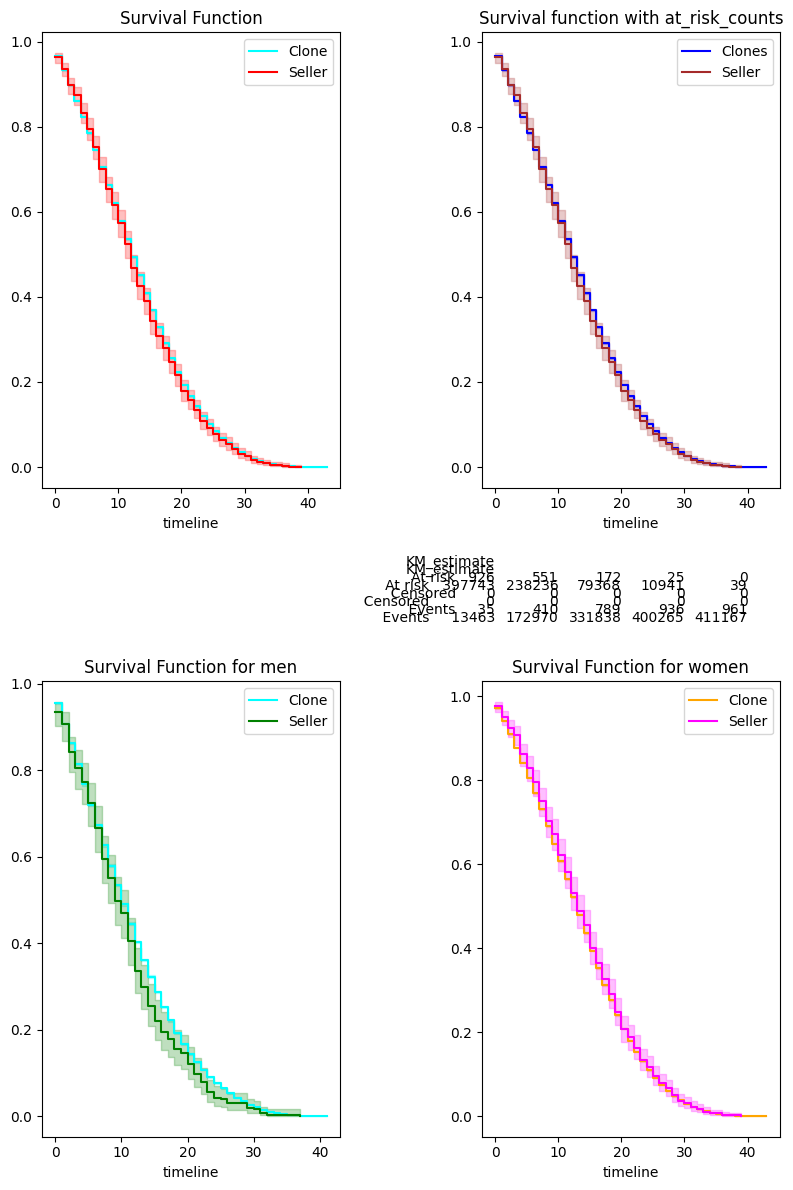

In [56]:
def convert_day_in_year(row):
  return int(row/365)


df['Ts'] = df['Ts'].apply(convert_day_in_year)
Ts = df.sort_values(by = 'Ts',ascending=True)

# Representing our survival curves
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 12))

# Divide clones
Clone = Ts[Ts['clone'] == 1]
People = Ts[Ts['clone'] == 0]

km1 = KaplanMeierFitter()
km2 = KaplanMeierFitter()

km1.fit(Clone['Ts'], event_observed= [1]*Clone.shape[0])
km1.plot_survival_function(ax=axes[0, 0], label= 'Clone', color = 'cyan')

km2.fit(People['Ts'], event_observed= [1]*People.shape[0])
km2.plot_survival_function(ax=axes[0, 0], label="Seller", color = 'red')

axes[0, 0].set_title('Survival Function')

# Survival function 'at_risk_counts'
km1.plot_survival_function(ax=axes[0, 1], at_risk_counts=True, color = 'blue', label = "Clones")
km2.plot_survival_function(ax=axes[0, 1], at_risk_counts=True, color = 'brown', label = "Seller")

axes[0, 1].set_title('Survival function with at_risk_counts')

# Men
sex_clone = Clone[Clone['b_sexe'] == 1]
sex_people = People[People['b_sexe']==1]

km1.fit(sex_clone['Ts'], event_observed= [1]*int(sex_clone.shape[0]), label= False)
km1.plot_survival_function(ax=axes[1, 0], color = 'cyan', label = "Clone")

km2.fit(sex_people['Ts'], event_observed= [1]*int(sex_people.shape[0]), label= False)
km2.plot_survival_function(ax=axes[1, 0], color = 'green', label = "Seller")

axes[1, 0].set_title('Survival Function for men')

# Women
sex_clone = Clone[Clone['b_sexe'] == 2]
sex_people = People[People['b_sexe']==2]

km1.fit(sex_clone['Ts'], event_observed= [1]*int(sex_clone.shape[0]), label= False)
km1.plot_survival_function(ax=axes[1, 1], color = 'orange', label = "Clone")

km2.fit(sex_people['Ts'], event_observed= [1]*int(sex_people.shape[0]), label= False)
km2.plot_survival_function(ax=axes[1, 1], color = 'magenta', label = "Seller")
axes[1, 1].set_title('Survival Function for women')

plt.tight_layout()
plt.show()

Let's try with an other module.

In [ ]:
# Download Data
df = pd.read_csv('Newclones_HF.csv')

# Keeping the "valid clones"
df = df[df['b_dateD'] >= df['dateA']]

# Create Td and Ts (lifetime in days)
df['Td'] = df['b_dateD'] - df['b_dateN']
df['Ts'] = df['b_dateD'] - df['dateA']

# Create the clone variable which is 1 if the individual is a clone
# and 0 otherwise (individual from the agency dataset)

agency = pd.read_csv('data_tetes_back_match.csv')
df['clone'] = 1

for i in tqdm(agency.index.to_list()):
  id = agency['id'][i]
  prenoms = agency['b_prenoms'][i]
  nom = agency['b_nom'][i]
  sex = agency['b_sexe'][i]

  sub_df = df[df['id']==id]

  for k in sub_df.index.to_list():
    compteur = 0
    if sub_df['b_nom'][k]==nom and sub_df['b_prenoms'][k]==prenoms and sub_df['b_sexe'][k]==sex:
      compteur += 1
      df['clone'][k] = 0

    if compteur > 1:
      print(nom,prenoms)

Ts = df.sort_values(by = 'Ts',ascending=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-71-1bb8b8246ba2>", line 2, in <cell line: 2>
    df = pd.read_csv('Newclones_HF.csv')
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 331, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 950, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 605, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 1442, in __init__
    self._engine = self._make_engi

Text(0.5, 0, 'time $t$')

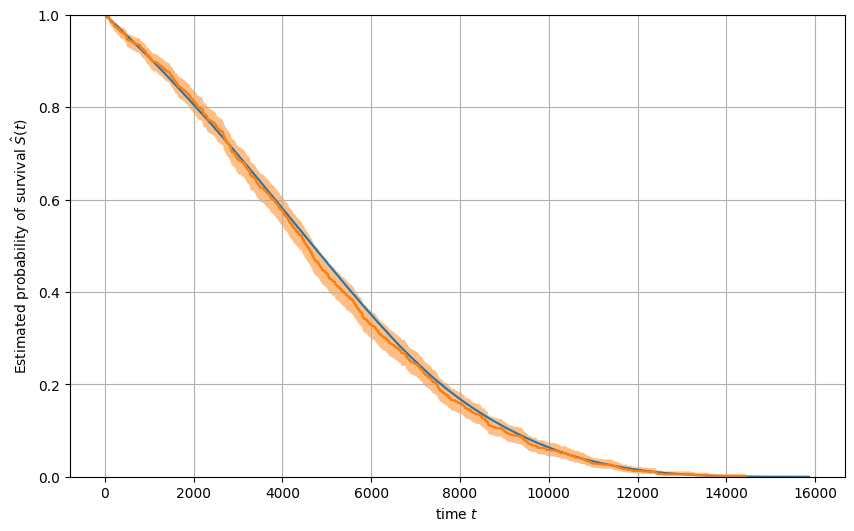

In [66]:
Clone = Ts[Ts['clone'] == 1]
People = Ts[Ts['clone'] == 0]

fig, ax = plt.subplots(figsize=(10, 6))

time1, survival_prob1, conf_int1 = kaplan_meier_estimator([True]*Clone.shape[0], Clone["Ts"], conf_type="log-log")
time2, survival_prob2, conf_int2 = kaplan_meier_estimator([True]*People.shape[0], People["Ts"], conf_type="log-log")


plt.step(time1, survival_prob1, where="post", label = "Clone")
plt.fill_between(time1, conf_int1[0], conf_int1[1], alpha=0.50, step="post")

plt.step(time2, survival_prob2, where="post", label = "Seller")
plt.fill_between(time2, conf_int2[0], conf_int2[1], alpha=0.50, step="post")

plt.ylim(0, 1)
plt.ylabel("Estimated probability of survival $\hat{S}(t)$")
plt.grid(True)
plt.xlabel("time $t$")

A little zoom over data

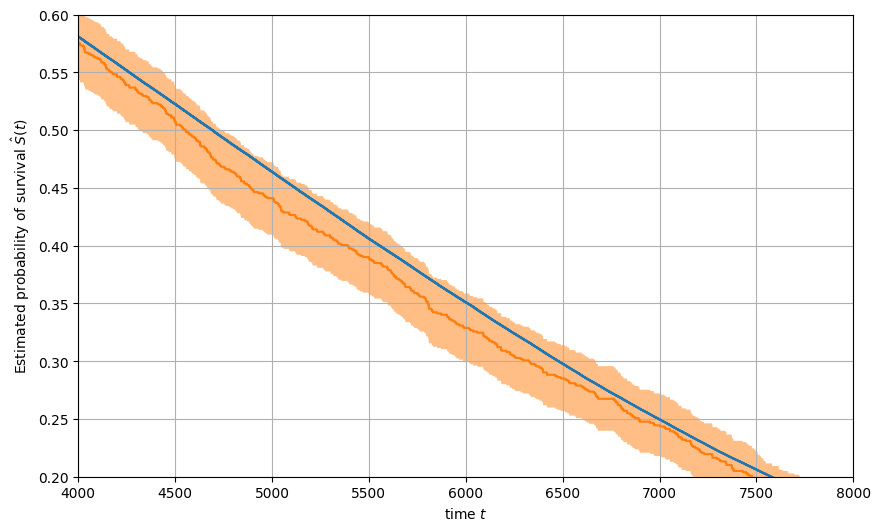

In [68]:
Clone = Ts[Ts['clone'] == 1]
People = Ts[Ts['clone'] == 0]

fig, ax = plt.subplots(figsize=(10, 6))

time1, survival_prob1, conf_int1 = kaplan_meier_estimator([True]*Clone.shape[0], Clone["Ts"], conf_type="log-log")
time2, survival_prob2, conf_int2 = kaplan_meier_estimator([True]*People.shape[0], People["Ts"], conf_type="log-log")


plt.step(time1, survival_prob1, where="post", label = "Clone")
plt.fill_between(time1, conf_int1[0], conf_int1[1], alpha=0.50, step="post")

plt.step(time2, survival_prob2, where="post", label = "Seller")
plt.fill_between(time2, conf_int2[0], conf_int2[1], alpha=0.50, step="post")


plt.ylabel("Estimated probability of survival $\hat{S}(t)$")
plt.grid(True)
plt.xlabel("time $t$")
plt.xlim(4000, 8000)
plt.ylim(0.2, 0.6)
plt.show()

We can split individuals based on the age at which they sell their property for life: <br>
- Categorie 1: people who sell before 65 <br>
- Categorie 2: people who sell between age 66 and 75 <br>
- Categorie 3: people who sell after age 76 <br>

In [3]:
Ts = df.sort_values(by = 'Ts',ascending=True)
Ts['categorie'] = 0
for i in Ts.index.to_list():
  age = int((Ts['dateA'][i]-Ts['b_dateN'][i])/365)
  if age<=65:
    Ts['categorie'][i]=1
  elif age>=66 and age<=75:
    Ts['categorie'][i]=2
  elif age>76:
    Ts['categorie'][i]=3

categories = [1,2,3]

<ipython-input-3-f26d13aad1c4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ts['categorie'][i]=3
<ipython-input-3-f26d13aad1c4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ts['categorie'][i]=2
<ipython-input-3-f26d13aad1c4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ts['categorie'][i]=1


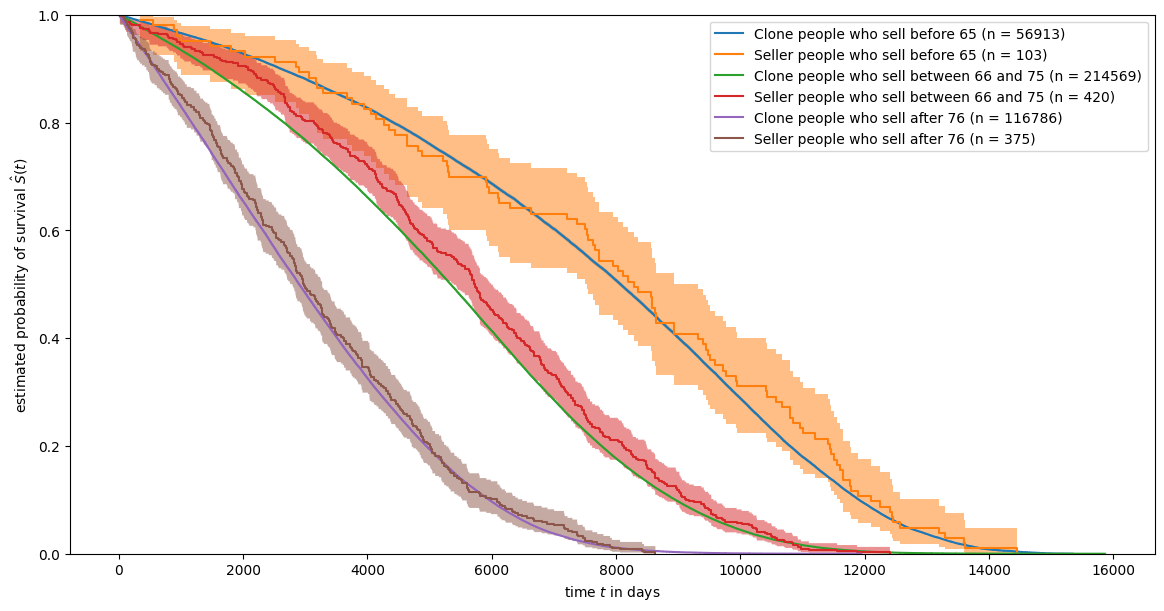

In [12]:
categories = [1,2,3]
title_categories = ['people who sell before 65', 'people who sell between 66 and 75', 'people who sell after 76' ]
Clone = Ts[Ts['clone'] == 1]
People = Ts[Ts['clone'] == 0]
i = 0
fig, ax = plt.subplots(figsize=(14,7))
for categorie in categories:
    mask_clone = Clone["categorie"] == categorie
    mask_people = People['categorie'] == categorie
    time1, survival_prob1, conf_int1 = kaplan_meier_estimator([True]*Clone[mask_clone].shape[0], Clone[mask_clone]["Ts"], conf_type="log-log")
    time2, survival_prob2, conf_int2 = kaplan_meier_estimator([True]*People[mask_people].shape[0], People[mask_people]["Ts"], conf_type="log-log")
    plt.step(time1, survival_prob1, where="post", label=f"Clone {title_categories[i]} (n = {mask_clone.sum()})")
    plt.fill_between(time1, conf_int1[0], conf_int1[1], alpha=0.50, step="post")
    plt.step(time2, survival_prob2, where="post", label=f"Seller {title_categories[i]} (n = {mask_people.sum()})")
    plt.fill_between(time2, conf_int2[0], conf_int2[1], alpha=0.50, step="post")
    i+=1
plt.ylim(0, 1)
plt.ylabel("estimated probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ in days")
plt.legend(loc="best")

We can use a linear model, **Cox’s proportional hazard’s model**, to estimate the impact each variable has on survival.

In [29]:
df = pd.read_csv('data_tetes_back_match.csv')
Ts = df.sort_values(by = 'Ts',ascending=True)


def get_age(dataframe):
  return (dataframe['dateD'] - dataframe['dateA'])/365

Ts['age_acte'] = get_age(Ts)

y = survival_events([True]*len(Ts['Ts']), Ts['Ts'].values)
estimator = CoxPHSurvivalAnalysis()
estimator.fit(Ts[['age_acte','annuity','downp']], y)
pd.Series(estimator.coef_, index= Ts[['age_acte','annuity','downp']].columns)

NameError: ignored